# Week 2 Assignment: CIFAR-10 Autoencoder

For this week, you will create a convolutional autoencoder for the [CIFAR10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset. You are free to choose the architecture of your autoencoder provided that the output image has the same dimensions as the input image.

After training, your model should meet loss and accuracy requirements when evaluated with the test dataset. You will then download the model and upload it in the classroom for grading.

Let's begin!

***Important:*** *This colab notebook has read-only access so you won't be able to save your changes. If you want to save your work periodically, please click `File -> Save a Copy in Drive` to create a copy in your account, then work from there.*  

## Imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

from keras.models import Sequential

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Load and prepare the dataset

The [CIFAR 10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset already has train and test splits and you can use those in this exercise. Here are the general steps:

* Load the train/test split from TFDS. Set `as_supervised` to `True` so it will be convenient to use the preprocessing function we provided.
* Normalize the pixel values to the range [0,1], then return `image, image` pairs for training instead of `image, label`. This is because you will check if the output image is successfully regenerated after going through your autoencoder.
* Shuffle and batch the train set. Batch the test set (no need to shuffle).


In [3]:
# preprocessing function
def map_image(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image # dataset label is not used. replaced with the same image input.

# parameters
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024


### START CODE HERE (Replace instances of `None` with your code) ###

# use tfds.load() to fetch the 'train' split of CIFAR-10
train_dataset = tfds.load("cifar10", as_supervised=True, split="train")

# preprocess the dataset with the `map_image()` function above
train_dataset = train_dataset.map(map_image)

# shuffle and batch the dataset
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)


# use tfds.load() to fetch the 'test' split of CIFAR-10
test_dataset = tfds.load("cifar10", as_supervised=True, split="test")

# preprocess the dataset with the `map_image()` function above
test_dataset = test_dataset.map(map_image)

# batch the dataset
test_dataset = test_dataset.batch(BATCH_SIZE)

### END CODE HERE ###

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteGFBPIP/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteGFBPIP/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


## Build the Model

Create the autoencoder model. As shown in the lectures, you will want to downsample the image in the encoder layers then upsample it in the decoder path. Note that the output layer should be the same dimensions as the original image. Your input images will have the shape `(32, 32, 3)`. If you deviate from this, your model may not be recognized by the grader and may fail.

We included a few hints to use the Sequential API below but feel free to remove it and use the Functional API just like in the ungraded labs if you're more comfortable with it. Another reason to use the latter is if you want to visualize the encoder output. As shown in the ungraded labs, it will be easier to indicate multiple outputs with the Functional API. That is not required for this assignment though so you can just stack layers sequentially if you want a simpler solution.

In [21]:
# suggested layers to use. feel free to add or remove as you see fit.
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D
from keras import backend as K

K.clear_session()
# use the Sequential API (you can remove if you want to use the Functional API)
# model = Sequential()

### START CODE HERE ###
# use `model.add()` to add layers (if using the Sequential API)
inputs = tf.keras.layers.Input(shape=((32,32,3)))

# ENCODER
conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

conv_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(max_pool_2)
max_pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_3)

# BOTTLENECK
bottle_neck = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(max_pool_3)
encoder_visualization = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

# DECODER
conv_1_decoder = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(encoder_visualization)
up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1_decoder)

conv_2_decoder = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2_decoder)

conv_3_decoder = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_2)
up_sample_3 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_3_decoder)

conv_4_decoder = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_3)

model = tf.keras.Model(inputs=inputs, outputs=conv_4_decoder, name="model")
encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)

# def encoder(inputs):
#   '''Defines the encoder with two Conv2D and max pooling layers.'''
#   conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
#   max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

#   conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
#   max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

#   return max_pool_2

# def bottle_neck(inputs):
#   '''Defines the bottleneck.'''
#   bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
#   encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

#   return bottle_neck, encoder_visualization

# def decoder(inputs):
#   '''Defines the decoder path to upsample back to the original image size.'''
#   conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
#   up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

#   conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
#   up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

#   conv_3 = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

#   return conv_3

# def convolutional_auto_encoder():
#   '''Builds the entire autoencoder model.'''
#   inputs = tf.keras.layers.Input(shape=(32, 32, 3,))
#   encoder_output = encoder(inputs)
#   bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
#   decoder_output = decoder(bottleneck_output)

#   model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
#   encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
#   return model, encoder_model

# model, convolutional_encoder_model = convolutional_auto_encoder()

### END CODE HERE ###

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168

## Configure training parameters

We have already provided the optimizer, metrics, and loss in the code below.

In [22]:
# Please do not change the model.compile() parameters
model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

## Training

You can now use [model.fit()](https://keras.io/api/models/model_training_apis/#fit-method) to train your model. You will pass in the `train_dataset` and you are free to configure the other parameters. As with any training, you should see the loss generally going down and the accuracy going up with each epoch. If not, please revisit the previous sections to find possible bugs.

*Note: If you get a `dataset length is infinite` error. Please check how you defined `train_dataset`. You might have included a [method that repeats the dataset indefinitely](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat).*

In [23]:
len(train_dataset)

391

In [24]:
len(train_dataset) // BATCH_SIZE

3

In [29]:
# parameters (feel free to change this)
train_steps = len(train_dataset) // BATCH_SIZE
val_steps = len(test_dataset) // BATCH_SIZE

### START CODE HERE ###
model.fit(train_dataset, validation_data=test_dataset, epochs=10)
### END CODE HERE ###

Epoch 1/10
391/391 [==============================] - 5s 13ms/step - loss: 0.0113 - accuracy: 0.6820 - val_loss: 0.0113 - val_accuracy: 0.6811
Epoch 2/10
391/391 [==============================] - 5s 12ms/step - loss: 0.0107 - accuracy: 0.6928 - val_loss: 0.0106 - val_accuracy: 0.6992
Epoch 3/10
391/391 [==============================] - 5s 12ms/step - loss: 0.0104 - accuracy: 0.6948 - val_loss: 0.0101 - val_accuracy: 0.6969
Epoch 4/10
391/391 [==============================] - 5s 12ms/step - loss: 0.0102 - accuracy: 0.6976 - val_loss: 0.0109 - val_accuracy: 0.7036
Epoch 5/10
391/391 [==============================] - 5s 12ms/step - loss: 0.0101 - accuracy: 0.6967 - val_loss: 0.0098 - val_accuracy: 0.7076
Epoch 6/10
391/391 [==============================] - 5s 12ms/step - loss: 0.0099 - accuracy: 0.6979 - val_loss: 0.0100 - val_accuracy: 0.7043
Epoch 7/10
391/391 [==============================] - 5s 12ms/step - loss: 0.0098 - accuracy: 0.6997 - val_loss: 0.0096 - val_accuracy: 0.7062

## Model evaluation

You can use this code to test your model locally before uploading to the grader. To pass, your model needs to satisfy these two requirements:

* loss must be less than 0.01
* accuracy must be greater than 0.6

In [30]:
result = model.evaluate(test_dataset, steps=10)

10/10 [==============================] - 0s 5ms/step - loss: 0.0094 - accuracy: 0.7076


If you did some visualization like in the ungraded labs, then you might see something like the gallery below. This part is not required.

<img src="https://storage.googleapis.com/tensorflow-3-public/assets/images/autoencoder.png" width="75%" height="75%"/>

In [50]:
import matplotlib.pyplot as plt
def display_one_row(disp_images, offset, shape=(8, 8)):
  '''Display sample outputs in one row.'''
  for idx, noisy_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    noisy_image = np.reshape(noisy_image, shape)
    plt.imshow(noisy_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(32,32,3))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(32,32,3))

1/1 [==============================] - 0s 21ms/step


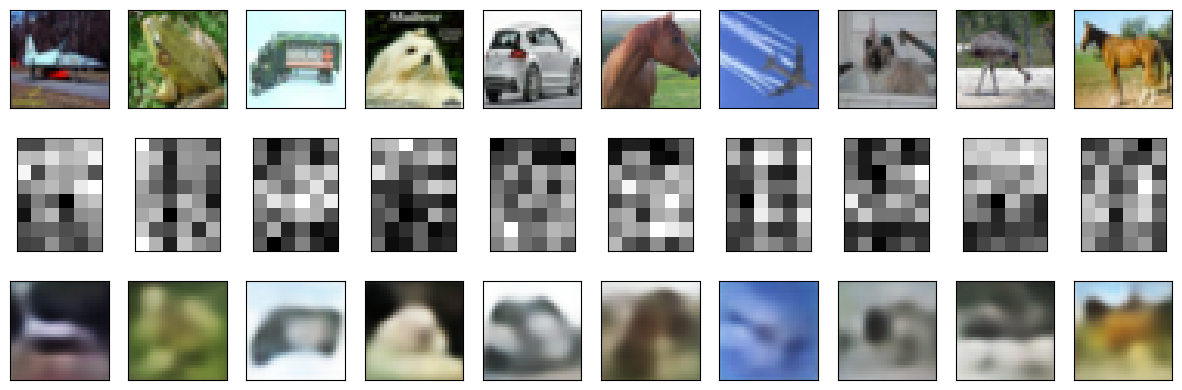

In [52]:
import numpy as np

# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 32, 32, 3))

# get the encoder ouput
encoded = encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(8,6))

## Save the Model

Once you're satisfied with the results, you can save your model and upload it to the grader in Coursera. Please run all succeeding cells to ensure that you will have a gradable submission. Otherwise, you might get this error message:

`There was a problem grading your submission. Check stderr for more details.`

First, save the model file in your Colab workspace.

In [53]:
# Save the model you just trained
model.save("temp_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Tensorflow releases minor and patch updates every few months ([sometimes quicker](https://pypi.org/project/tensorflow/#history)). Oftentimes, the code and syntax won't change but the newer versions will have a different model definition under the hood. The next cells will convert your newer model to one that the grader can read. You won't have to do this in your personal projects. This is just an extra step for grading.

In [54]:
# Install packages for compatibility with the autograder

# NOTE: You can safely ignore errors about version incompatibility of
# Colab-bundled packages (e.g. xarray, pydantic, etc.)

!pip install tensorflow==2.8.0 --quiet
!pip install keras==2.8.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 103.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 62.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.8.0 which is incompatible.


Wait for the cell above to complete. After that, **go to `Runtime > Restart Session` and wait for the kernel to reconnect.** This is necessary so you can reload Tensorflow with the version installed above. Run the next cell to check if you have the correct version. You will get an `AssertionError` if you didn't restart the session.

In [2]:
import tensorflow as tf

# Check if you have the correct Tensorflow version
assert tf.__version__ == '2.8.0', f'You have TF{tf.__version__}. Please install the grader-compatible Tensorflow and select Runtime > Restart Session'

If you didn't get an error above, you can finally convert the model.

In [3]:
# Load the model you saved earlier
model = tf.keras.models.load_model("temp_model.h5", compile=False)

# For this assignment only. The model has to be compiled with these settings.
model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

# Save the model with the compatible TF version
model.save("mymodel.h5")

Please look for `mymodel.h5` in the File Explorer on the left and download it. Then go back to the Coursera classroom and upload it to `My Submissions` tab of the Week 2 assignment. Alternatively, you can also use the cell below to download the model.



In [4]:
# You can also use this cell as a shortcut for downloading your model
from google.colab import files
files.download("mymodel.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Congratulations on completing this week's assignment!**